### We want to check various properties of the toy problem. Namely, we want to see if the RMS between the signal and noise is the same. Then, we want to check that the problem is not linearly separable.

In [2]:
import numpy as np
from data_fns import noisy_sin_signal, data_matrix
from estimator import RFClassifier, relu, sigmoid
import numpy.linalg as la
import dask
import matplotlib.pyplot as plt

__First, let's visualize the toy problem.__

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 9 Text yticklabel objects>)

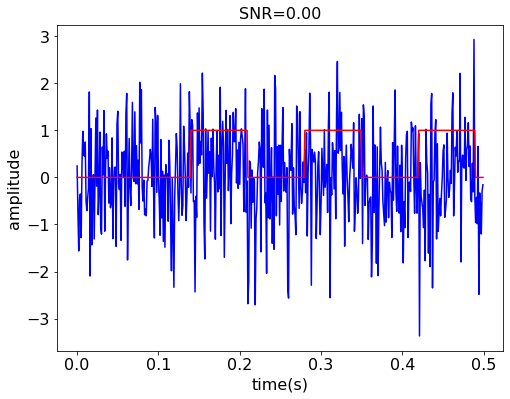

In [3]:
a = 0.01 # a =[0.999, 0.8, 0.5, 0.01]
snr = a ** 2 / (1 - a ** 2)
signal, label = noisy_sin_signal(f_s=1000, dur=10, sig_dur=0.07, f_signal=50, a=a, seed=34)
t = np.arange(0, 10, 1/1000)


fig = plt.figure(figsize=(8,6))
plt.title('SNR=%0.2f' % snr, fontsize=16)
plt.plot(t[:500], signal[:500], 'b')
plt.plot(t[:500], label[:500], 'r')
plt.xlabel('time(s)', fontsize=16)
plt.ylabel('amplitude', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('figures/data_gen/time_series_snr=%0.2f.png' % a)

__Now, let's check if the signal and noise segments have the same RMS across various SNR regimes.__

We have

$$
a^2 + \sigma_2^2 = 1 \\
sig = \sqrt{2} a \sin(t) + \sigma_2 N(0, 1)\\
noise = N(0, 1)
$$
This ensures that the RMS between the signal and the noise is constant as one varies a.

$$
RMS_{signal} = \dfrac{1}{2 \pi} \int_0^{2 \pi} (\sqrt{2} a \sin(t) + \sigma_2 N(0, 1))^2 dt = a^2 + \sigma_2^2 = 1 \\
RMS_{noise} = \dfrac{1}{2 \pi} \int_0^{2 \pi} (N(0, 1))^2 dt = 1 \; \; \text{(property of Brownian motion)}
$$

In [4]:
### Feb 26, 20: Worked with Kam to make a new scaling that gives the same rms for the noise and the signal
import numpy as np

T = 100 * np.pi
n = 100 * 1000
t = np.linspace(0, T, n)
for a in np.linspace(0, 1, 5):
    print(a)
    sigma_2 = np.sqrt(1 - a**2)
    sig = np.sqrt(2) * a * np.sin(t) + sigma_2 * np.random.randn(len(t))
    noise = np.random.randn(len(t))
    print(np.sum(sig**2) / T )
    print(np.sum(noise**2) / T)

0.0
320.357915570325
318.3658497464227
0.25
318.8929401844653
318.7282565183153
0.5
318.6441172959628
316.73326014678184
0.75
319.01057037357174
317.78627189508944
1.0
318.3067030849289
318.6774059763765


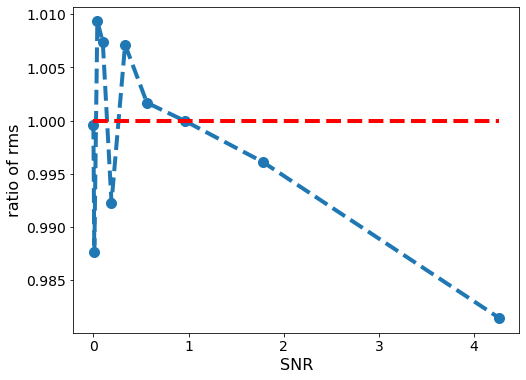

In [30]:
ratio = []
a_list = np.arange(0, 1, 0.1)
for a in a_list:
    signal, label = noisy_sin_signal(a=a)
    X, y = data_matrix(signal, label, 100)
    rms_sig = np.mean(la.norm(X[y == 1], axis=1) / np.sqrt(100))
    rms_noise = np.mean(la.norm(X[y == 0], axis=1) / np.sqrt(100))
    ratio.append(rms_sig/rms_noise)
    
snr = a_list ** 2 / (1 - a_list ** 2)
fig = plt.figure(figsize=(8, 6))
plt.plot(snr, ratio, '--o', lw=4, markersize=10)
plt.plot(snr, np.ones_like(ratio), '--r', lw=4)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('ratio of rms', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/data_gen/rms_ratio.png')

__Comment__: We see that the ratio of RMS between signal and noise segments is 1 across various SNR regimes.

__Now, we want to check whether the toy problem is linearly separable or not.__

In [5]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:44681 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [6]:
def parallel_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [7]:
params = {'width': 20, 'weights': None, 'nonlinearity': lambda x: x}

In [42]:
%%time
scores = []
a_list = np.arange(0, 1, 0.1)
for _ in range(5):
    temp = []
    for a in a_list:
        signal, label = noisy_sin_signal(f_s=1000, dur=10, sig_dur=0.07, f_signal=50, a=a)
        X, y = data_matrix(signal, label, N=40)

        # separate into train and test set
        idx = int(len(X) * 2 / 3)
        X_train, y_train = X[:idx], y[:idx]
        X_test, y_test = X[idx:], y[idx:]

        #train and classify
        lazy_results = [dask.delayed(parallel_clf)(RFClassifier, params, X_train, y_train, 
                                                   X_test, y_test) for _ in range(3)]
        %time temp.append(dask.compute(*lazy_results))
    scores.append(temp)

CPU times: user 273 ms, sys: 48.5 ms, total: 321 ms
Wall time: 1.94 s
CPU times: user 294 ms, sys: 56.8 ms, total: 350 ms
Wall time: 2.03 s
CPU times: user 300 ms, sys: 76.9 ms, total: 377 ms
Wall time: 2.15 s
CPU times: user 210 ms, sys: 53.9 ms, total: 264 ms
Wall time: 1.67 s
CPU times: user 284 ms, sys: 94 ms, total: 378 ms
Wall time: 2.03 s
CPU times: user 255 ms, sys: 65.4 ms, total: 320 ms
Wall time: 1.86 s
CPU times: user 235 ms, sys: 59.8 ms, total: 295 ms
Wall time: 1.77 s
CPU times: user 300 ms, sys: 51.4 ms, total: 351 ms
Wall time: 2.13 s
CPU times: user 279 ms, sys: 62.4 ms, total: 342 ms
Wall time: 1.83 s
CPU times: user 258 ms, sys: 77.4 ms, total: 335 ms
Wall time: 1.82 s
CPU times: user 264 ms, sys: 46.5 ms, total: 311 ms
Wall time: 1.92 s
CPU times: user 272 ms, sys: 55.2 ms, total: 327 ms
Wall time: 1.95 s
CPU times: user 262 ms, sys: 68.2 ms, total: 330 ms
Wall time: 1.99 s
CPU times: user 276 ms, sys: 58 ms, total: 334 ms
Wall time: 2.13 s
CPU times: user 302 ms, 

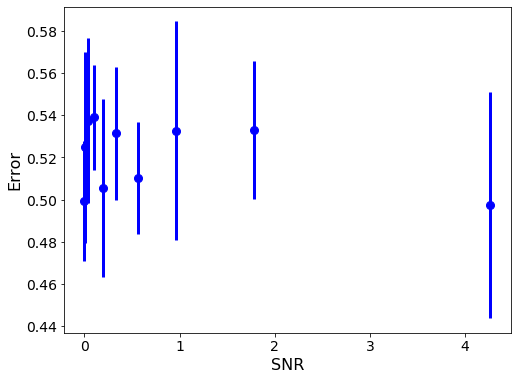

In [48]:
snr = a_list ** 2 / (1 - a_list ** 2)
mean_err = 1 - np.mean(np.mean(scores, axis=2), axis=0)
std_err = np.std(np.mean(scores, axis=2), axis=0)

fig = plt.figure(figsize=(8, 6))
plt.errorbar(snr, mean_err, yerr=std_err, fmt='bo', markersize=8, lw=3)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/data_gen/linear_separability.png')

02_26_20/  data_gen/  forget_filter/  rand_classification/
